# SurvSHAP vs DeepLift vs Integrated Gradients
### J. Krajewski, S. Frejlak, M. Wojtala

### Experiment 1: evaluation on artificial datsa

#### Imports

In [1]:
!pip3 install torchtuples
!pip3 install pycox

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy.integrate import trapezoid

import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torch.nn as nn
import torch.optim as optim
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle
from typing import Optional, Callable, Any
from sksurv.functions import StepFunction
from pycox.evaluation import EvalSurv
from dataclasses import dataclass
from captum.attr import DeepLift, IntegratedGradients
import plotly.graph_objects as go
from survshap import SurvivalModelExplainer, ModelSurvSHAP, PredictSurvSHAP

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The next part of experiment 1 will be here after overcoming technical difficulties...

#### Wrappers

In [2]:
@dataclass
class TrainConf:
    optimizer_fn: Callable[[nn.Module], optim.Optimizer] \
        = lambda net: optim.Adam(net.parameters(), lr=1e-3)
    device: Optional[torch.device] = None
    batch_size: int = 256
    epochs: int = 1
    callbacks: Any = None
    verbose: bool = False
    num_workers: int = 0
    shuffle: bool = False
    metrics: Any = None
    val_data: Optional[torch.Tensor] = None
    val_batch_size: int = 8224


class DeepHitSingle_:
    """A sksurv-like wrapper around pycox's DeepHitSingle."""

    def __init__(self, model: DeepHitSingle):
        """Create an instance.
        :param net: NN at the core of DeepHit. The number of output features
         is the number of cuts/timestamps.
        :param timestamps: (Optional) Predefined timestamps/steps to use. 
        Number of them must be equal to the dimensionality of net's output 
        space. If not provided, default cuts are used (see pycox docs for more 
        details.)
        :param alpha, sigma: Parameters for the pycox.models.DeepHitSingle 
        class."""
        self._model = model
    
    def fit(self, X_train, y_train, *train_args, **train_kwargs):
        # If the cuts are unspecified, we guess it by dry-running the net 
        # and checking the dimensionality of the output space.
        with torch.no_grad():
            self._model.net.eval()
            num_features = X_train.shape[1]
            dummy = torch.empty((1, num_features), dtype=torch.float32)
            res = self._model.net(dummy)[0]
            self._model.net.train()
        cuts = res.shape[0]
        
        self.tf = DeepHitSingle.label_transform(cuts)
        self.tf.fit(y_train[0], y_train[1].astype(bool))
        self._log = self._model.fit(X_train, y_train, *train_args, **train_kwargs)
        
        self.event_times_ = self.tf.cuts
        return self._log
    
    def predict_surv_df(self, X):
        X = torch.tensor(np.asarray(X), dtype=torch.float32)
        return self._model.predict_surv_df(X).astype("float32")
    
    def predict_survival_function(self, X, return_array=False):
        """Predict survival function. See sksurv models for more details."""

        surv_df = self.predict_surv_df(X)

        event_times_ = surv_df.index.values
        sf_values = surv_df.T.values

        if return_array:
            return sf_values
        else:
            return np.array([
                StepFunction(event_times_, values)
                for values in sf_values
            ])

    def predict_cumulative_hazard_function(self, X, return_array=False):
        raise NotImplementedError
    
    def score(self, X, y):
        surv = self.predict_surv_df(X)

        eval = EvalSurv(
            surv=surv,
            durations=y["duration"],
            events=y["event"],
            censor_surv="km",
        )
        return eval.concordance_td(method="antolini")

In [3]:
class IGExplainer:
    def __init__(self, model: DeepHitSingle_, data=None, y=None):
        self.model = model
        if data is not None:
            data = torch.tensor(data, dtype=torch.float32)
            self.baselines = data.mean(dim=0)
        else:
            self.baselines = None
    
    def __call__(self, X: np.array):
        inputs = torch.tensor(X, dtype=torch.float32)
        if self.baselines is not None:
            baselines = self.baselines.broadcast_to(inputs.shape)
        else:
            baselines = inputs.mean(dim=0).broadcast_to(inputs.shape)

        ig = IntegratedGradients(self.model._model.net)

        attr_values = []
        for idx in range(len(self.model.event_times_)):
            attrs = ig.attribute(inputs, baselines, target=idx)
            attr_values.append(attrs)
        attr_values = torch.stack(attr_values, dim=2).detach().numpy()

        X = pd.DataFrame(X, columns=[f"var_{i}" for i in range(X.shape[1])])
        var_attr_values = {}
        for var_idx, var in enumerate(X.columns):
            var_attr_values[var] = [
                StepFunction(
                    x=self.model.event_times_,
                    y=np.cumsum(attr_values[obs_idx,var_idx]),
                ) for obs_idx in range(len(X))
            ]
        
        return pd.DataFrame(var_attr_values)

In [4]:
class SurvShapExplainer:
    """A bit more shap-esque Explainer wrapper for SurvSHAP."""

    def __init__(self, model, data=None, y=None, calculation_method="kernel", aggregation_method="integral", path="average", B=25, random_state=42, pbar=False):
        self.model = model
        self.calculation_method = calculation_method
        self.aggregation_method = aggregation_method
        self.path = path
        self.B = B
        self.random_state = random_state
        self.exp = SurvivalModelExplainer(self.model, data=data, y=y)
        self.pbar = pbar

    def __call__(self, observations: pd.DataFrame, timestamps=None) -> pd.DataFrame:
        """Predict SHAP values for a number of observations. In this case, we 
        deal with survival functions in the form of StepFunction, so likewise 
        the output SHAP values will be step functions.
        :param observations: Dataframe with shape (num_obs, num_features).
        :return: A dataframe with shape (num_obs, num_features), where each 
        "cell" contains a StepFunction being the SHAP attribution for a given 
        observation and a given value."""
        # observations = pd.DataFrame(observations, columns=[f"var_{i}" for i in range(observations.shape[1])])
        print(f'type of observations: {type(observations)}')
        if timestamps is None:
            timestamps = self.model.event_times_

        skip = ["variable_str", "variable_name", "variable_value", "B", "aggregated_change", "index"]

        all_results = []
        
        idx_seq = range(len(observations))
        if self.pbar:
            idx_seq = tqdm(idx_seq)
        
        for idx in idx_seq:
            print(f'idx: {idx}')
            print(f'type of observations: {type(observations)}')
            obs = observations.iloc[[idx]]
            shap = PredictSurvSHAP(
                calculation_method=self.calculation_method,
                aggregation_method=self.aggregation_method,
                path=self.path,
                B=self.B,
                random_state=self.random_state,
            )

            shap.fit(self.exp, obs, timestamps)
            obs_df = shap.result
            obs_df.insert(len(skip)-1, "index", idx)
            all_results.append(obs_df)
        
        res_df = pd.concat(all_results)
            
        g = res_df.groupby(by="variable_name")

        var_attr_values = {}
        for var in g.groups:
            grp: pd.DataFrame = g.get_group(var)
            grp = grp.sort_values(by=["index"])
            attr_values = grp.iloc[:,len(skip):].values
            var_attr_values[var] = [
                StepFunction(timestamps, attr_values_)
                for attr_values_ in attr_values
            ]
            
        res_df = pd.DataFrame(var_attr_values)
        res_df = res_df.set_index(observations.index, drop=True)
        return res_df

In [5]:
def plot_expl(expl):
    fig = go.Figure()
    for var in expl.index:
        shap_f = expl[var]
        fig.add_trace(go.Scatter(
            x=shap_f.x, y=shap_f.y,
            mode="lines",
            line=dict(shape="hv"),
            name=var,
        ))
    return fig

### Experiment 2: Real-world use case: predicting survival of patients with heart failure

#### Preparing data and deep model

In [6]:
df_train = pd.read_csv('data/exp3_heart_failure_dataset.csv')
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1


In [7]:
cols_standardize = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
cols_leave = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [8]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [9]:
num_durations = 100

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['DEATH_EVENT'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

x_train.transpose()

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

#### Training deep model

In [10]:
in_features = x_train.shape[1]
num_nodes = [4, 4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [11]:
model = DeepHitSingle(net, tt.optim.Adam(0.0001), duration_index=labtrans.cuts)

In [12]:
batch_size = 32
epochs = 1500
callbacks = []

train_args = [batch_size, epochs, callbacks]
train_kwargs = {'val_data': val}

In [13]:
model_ = DeepHitSingle_(model)
log = model_.fit(x_train, y_train, *train_args, **train_kwargs)

0:	[0s / 0s],		train_loss: 0.6812,	val_loss: 0.7266
1:	[0s / 0s],		train_loss: 0.6877,	val_loss: 0.7325
2:	[0s / 0s],		train_loss: 0.6825,	val_loss: 0.7370
3:	[0s / 0s],		train_loss: 0.6825,	val_loss: 0.7409
4:	[0s / 0s],		train_loss: 0.6805,	val_loss: 0.7428
5:	[0s / 0s],		train_loss: 0.6794,	val_loss: 0.7445
6:	[0s / 0s],		train_loss: 0.6825,	val_loss: 0.7448
7:	[0s / 0s],		train_loss: 0.6706,	val_loss: 0.7449
8:	[0s / 0s],		train_loss: 0.6802,	val_loss: 0.7451
9:	[0s / 0s],		train_loss: 0.6797,	val_loss: 0.7443
10:	[0s / 0s],		train_loss: 0.6808,	val_loss: 0.7443
11:	[0s / 0s],		train_loss: 0.6743,	val_loss: 0.7440
12:	[0s / 0s],		train_loss: 0.6747,	val_loss: 0.7442
13:	[0s / 0s],		train_loss: 0.6804,	val_loss: 0.7440
14:	[0s / 0s],		train_loss: 0.6708,	val_loss: 0.7436
15:	[0s / 0s],		train_loss: 0.6735,	val_loss: 0.7435
16:	[0s / 0s],		train_loss: 0.6741,	val_loss: 0.7433
17:	[0s / 0s],		train_loss: 0.6740,	val_loss: 0.7434
18:	[0s / 0s],		train_loss: 0.6741,	val_loss: 0.7427
19:

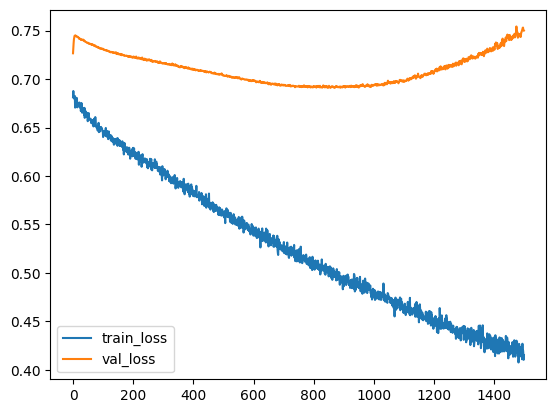

In [14]:
_ = log.plot()

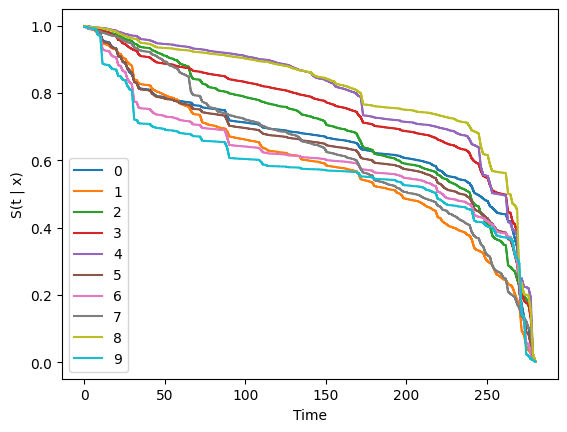

In [15]:
surv = model.interpolate(20).predict_surv_df(x_test)
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [16]:
model_._model.predict_surv_df(x_test).iloc[:, :1].shape
# To pokazuje, że punktów w czasie jest tyle samo, więc możemy tu porównać/podzielić z późniejszym

(200, 1)

#### Explaining the deep model with DeepHitSingle

In [17]:
x_train[:4]

array([[ 1.1571323 ,  0.01446794, -1.4574322 ,  0.07898265,  0.5023152 ,
        -1.527015  ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ],
       [-0.5321339 ,  7.0084233 ,  0.02808571,  0.0601825 , -0.25905535,
        -0.14800854,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [-0.95445037, -0.43808776, -1.4574322 , -0.55075383,  0.5023152 ,
         0.08182586,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 2.4240818 , -0.49958152,  0.19314325, -0.61945236,  0.6926579 ,
        -1.0673462 ,  1.        ,  0.        ,  1.        ,  1.        ,
         1.        ]], dtype=float32)

In [18]:
ig_expl = IGExplainer(model_, x_val, y_val)
ig_expl0 = ig_expl(x_val[[19]]).iloc[0]
plot_expl(ig_expl0)

#### Explaining the deep model with survSHAP

In [19]:
x_val_surv = pd.DataFrame(x_val, columns=[f"var_{i}" for i in range(x_val.shape[1])])
y_val_surv = []
for i in range(len(y_val[0])):
    y_val_surv.append((bool(y_val[1][i]), y_val[0][i]))
y_val_surv = np.array(y_val_surv, np.dtype([('event', '?'), ('duration', '<f8')]))
dh_expl = SurvShapExplainer(model_, x_val_surv, y_val_surv)
dh_expl0 = dh_expl(x_val_surv.iloc[[19]]).iloc[0]
plot_expl(dh_expl0)

type of observations: <class 'pandas.core.frame.DataFrame'>
idx: 0
type of observations: <class 'pandas.core.frame.DataFrame'>
